In [ ]:
!pip install kaggle

In [ ]:
!pip install tensorflow

In [1]:
import zipfile
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Bidirectional, Dense, Dropout, BatchNormalization
from tensorflow.keras import regularizers ,layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Step 1. 連接kaggle API 並下載音檔

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 先登入kaggle並取得Kaggle API Token(kaggle.json) => 再上傳上來

from google.colab import files
files.upload()  # 上傳kaggle.json

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
!kaggle datasets download -d carlthome/gtzan-genre-collection

drive_path = '/content/drive/MyDrive/gtzan_dataset'
os.makedirs(drive_path, exist_ok=True)

# 解壓縮到 Google Drive
with zipfile.ZipFile('gtzan-genre-collection.zip', 'r') as zip_ref:
    zip_ref.extractall(drive_path)

Dataset URL: https://www.kaggle.com/datasets/carlthome/gtzan-genre-collection
License(s): copyright-authors
 98% 1.12G/1.14G [00:04<00:00, 402MB/s]
100% 1.14G/1.14G [00:04<00:00, 296MB/s]


# Step 2. 切割音檔以提取特徵

In [ ]:
genres = {
    'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4,
    'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9
}


base_path = '/content/drive/MyDrive/gtzan_dataset/genres'
output_path = '/content/drive/MyDrive/gtzan_dataset/features'
os.makedirs(output_path, exist_ok=True)

segment_duration = 2 # 切割音訊的長度(秒數)
target_frames = 173 # 音訊轉為特徵的時間軸長度
target_features = 89

# 特徵提取函式
def extract_features(y, sr=22050, target_frames=173):
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=512, hop_length=256, n_mels=64)
    chroma = librosa.feature.chroma_stft(y=y, sr=sr, hop_length=256)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, hop_length=256, n_mfcc=13)
    mel_db = librosa.power_to_db(mel, ref=np.max)

    features = np.vstack([mel_db, chroma, mfcc])  # shape: (89, T)

    if features.shape[1] < target_frames:
        features = np.pad(features, ((0, 0), (0, target_frames - features.shape[1])), mode='constant')
    else:
        features = features[:, :target_frames]

    return features.T[np.newaxis, ..., np.newaxis]  # shape: (1, 173, 89, 1)



for genre in genres:
    genre_path = os.path.join(base_path, genre)
    for filename in os.listdir(genre_path):
        audio_path = os.path.join(genre_path, filename)
        y, sr = librosa.load(audio_path, sr=None)
        total_duration = librosa.get_duration(y=y, sr=sr)
        num_segments = int(total_duration // segment_duration)

        for i in range(num_segments):
            start = i * segment_duration
            y_seg, _ = librosa.load(audio_path, sr=sr, offset=start, duration=segment_duration)

            # 使用 extract_features()
            features = extract_features(y_seg, sr)

            # 儲存特徵為pkl
            out_filename = f'{genre}_{os.path.splitext(filename)[0]}_seg{i}.pkl'
            out_fullpath = os.path.join(output_path, out_filename)
            with open(out_fullpath, 'wb') as f:
                pickle.dump(features, f)

In [ ]:
X = []
y = []
data_path = '/content/drive/MyDrive/gtzan_dataset/features'

for file in os.listdir(data_path):
    if file.endswith('.pkl'):
        label = genres[file.split('_')[0]]
        # 轉為符合時間序列格式的shape以代入模型中
        with open(os.path.join(data_path, file), 'rb') as f:
            features = pickle.load(f)
            if features.ndim == 4 and features.shape[0] == 1:
                features = features[0]  # 移除 batch 維度
            X.append(features)
            y.append(label)

In [ ]:
X = np.array(X)
y = np.array(y)

# 分割資料集 => train: 75%, validation: 12.5%, test: 12.5%
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# 將標籤改為One-hot encoding, 以符合分類模型的需要
y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_valid_cat = tf.keras.utils.to_categorical(y_valid, num_classes=10)
y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes=10)


In [ ]:
# reshape為(number, 173, 89, 1)以符合CNN模型的輸入格式
X_train_cnn = X_train[..., np.newaxis] # (number, timestamps, feature, channel)
X_valid_cnn = X_valid[..., np.newaxis]
X_test_cnn  = X_test[..., np.newaxis]

# Step 3. 訓練

架構: CNN+Transformer

CNN將音訊當作圖像處理, 而Transformer具彌補CNN缺乏長期記憶的能力

輸入格式: (batch_size, 173, 89, 1)

Layer 1(輸入層): Input(shape=(173, 89, 1))

Layer 2(卷積層): Conv2D(8) + MaxPool2D + BatchNorm

Layer 3(Reshape層): Reshape((86, 352))

Layer 4(MultiHead Attention): MultiHeadAttention(num_heads=1, key_dim=16)

Layer 5(殘差 + LayerNorm 1): Add([x, attn]) + LayerNormalization()

Layer 6(Feed Forward (FFN)): Dense(352) + Add + LayerNorm

Layer 7(Global Pooling): GlobalAveragePooling1D()

Layer 8(全連接 + Dropout): Dense(32) + Dropout(0.5)

Layer 9(輸出層): Dense(10, activation='softmax')

In [ ]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-5,
    verbose=1
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True,
    verbose=1
)

def cnn_transformer_model(input_shape=(173, 89, 1), num_classes=10):
    l2_reg = 1e-4
    inputs = tf.keras.Input(shape=input_shape)

    x = layers.Conv2D(8, (3, 3), activation='relu', padding='same',
                      kernel_regularizer=regularizers.l2(l2_reg))(inputs)
    x = layers.MaxPooling2D((2, 2))(x)  # (86, 44, 8)
    x = layers.BatchNormalization()(x)

    x = layers.Reshape((86, 44 * 8))(x)  # = (86, 352)

    attn = layers.MultiHeadAttention(num_heads=1, key_dim=16)(x, x)
    x = layers.Add()([x, attn])
    x = layers.LayerNormalization()(x)

    ff = layers.Dense(352, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = layers.Add()([x, ff])
    x = layers.LayerNormalization()(x)

    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    return tf.keras.Model(inputs, outputs)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 173, 89,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 173, 89,   │         80 │ input_layer_1[0]… │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 86, 44, 8) │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 86, 44, 8) │         32 │ max_pooling2d_1[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 86, 352)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 86, 352)   │     22,928 │ reshape_1[0][0],  │
│ (MultiHeadAttentio… │                   │            │ reshape_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 86, 352)   │          0 │ reshape_1[0][0],  │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 86, 352)   │        704 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 86, 352)   │    124,256 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 86, 352)   │          0 │ layer_normalizat… │
│                     │                   │            │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 86, 352)   │        704 │ add_3[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 352)       │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 32)        │     11,296 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 32)        │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 10)        │        330 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 160,330 (626.29 KB)

 Trainable params: 160,314 (626.23 KB)

 Non-trainable params: 16 (64.00 B)

Epoch 1/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.2335 - loss: 2.1939 - val_accuracy: 0.3965 - val_loss: 1.6344 - learning_rate: 0.0010
Epoch 2/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.3853 - loss: 1.7532 - val_accuracy: 0.5800 - val_loss: 1.3596 - learning_rate: 0.0010
Epoch 3/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.4367 - loss: 1.5913 - val_accuracy: 0.6419 - val_loss: 1.1363 - learning_rate: 0.0010
Epoch 4/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5034 - loss: 1.4027 - val_accuracy: 0.6302 - val_loss: 1.0974 - learning_rate: 0.0010
Epoch 5/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5809 - loss: 1.2370 - val_accuracy: 0.7220 - val_loss: 0.8900 - learning_rate: 0.0010
Epoch 6/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.6183 - loss: 1.1262 - val_accuracy: 0.6969 - val_loss: 0.9247 - learning_rate: 0.0010
Epoch 7/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6246 - loss: 

模型路徑: /content/drive/MyDrive/cnn_transformer_model.h5
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9132 - loss: 0.3358
Test Accuracy (CNN): 0.9082
Test Loss (CNN): 0.3508
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step


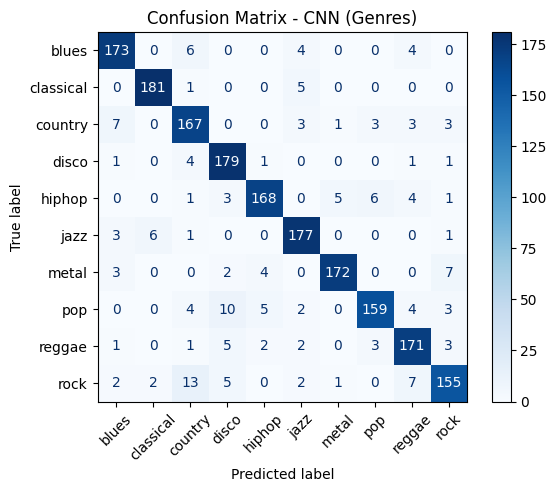

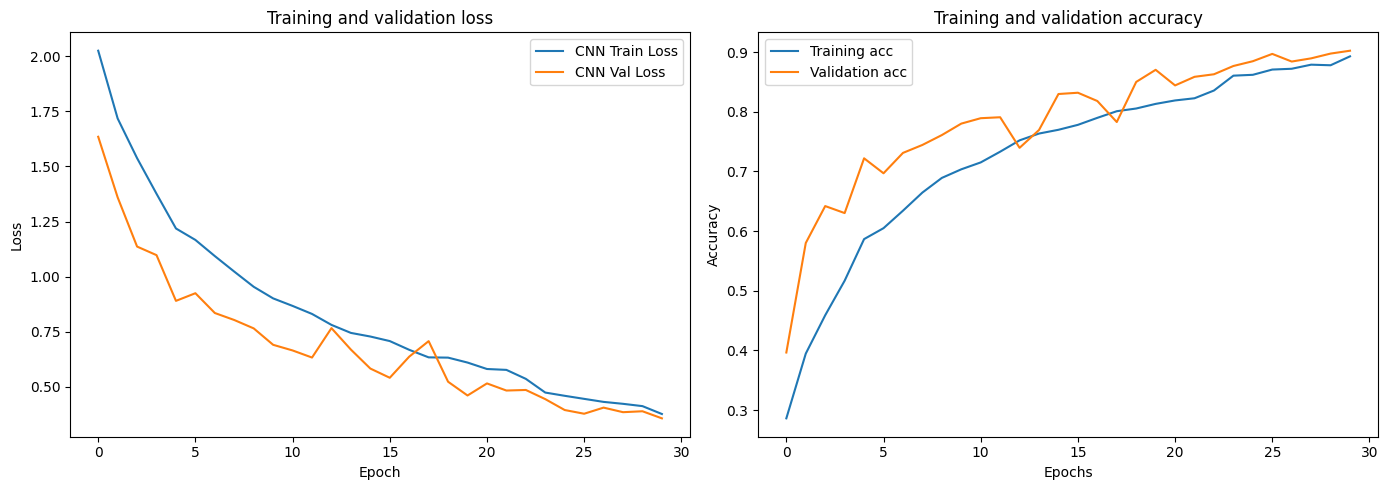

In [ ]:
cnn_model = cnn_transformer_model()
cnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

cnn_model.summary()

# 接著進行訓練
cnn_history = cnn_model.fit(
    X_train_cnn, y_train_cat,
    validation_data=(X_valid_cnn, y_valid_cat),
    epochs=30,
    batch_size=64,
    callbacks=[reduce_lr, early_stop],
    verbose=1
)
model_save_path = "/content/drive/MyDrive/cnn_transformer_model.h5"
cnn_model.save(model_save_path)
print(f"模型路徑: {model_save_path}")

# 評估分數
cnn_loss, cnn_acc = cnn_model.evaluate(X_test_cnn, y_test_cat)
print(f"Test Accuracy (CNN): {cnn_acc:.4f}")
print(f"Test Loss (CNN): {cnn_loss:.4f}")

# Confusion Matrix
y_pred_cnn = np.argmax(cnn_model.predict(X_test_cnn), axis=1)
cm_cnn = confusion_matrix(y_test, y_pred_cnn)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_cnn, display_labels=list(genres.keys()))
disp.plot(xticks_rotation=45, cmap='Blues')
plt.title("Confusion Matrix - CNN (Genres)")
plt.show()

# Loss曲線
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(cnn_history.history['loss'], label='CNN Train Loss')
plt.plot(cnn_history.history['val_loss'], label='CNN Val Loss')
plt.title("Training and validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# accuracy曲線
plt.subplot(1, 2, 2)
plt.plot(cnn_history.history['accuracy'], label='Training acc')
plt.plot(cnn_history.history['val_accuracy'], label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Step 4. 生成音樂

使用Huggingface的facebook/musicgen-small的音樂生成api

在prompts當中輸入想要的音樂類型以及風格即能生成音樂

In [3]:
!pip install git+https://github.com/huggingface/transformers.git scipy librosa soundfile tensorflow
!pip install transformers==4.37.2 accelerate torchaudio --quiet

  Cloning https://github.com/huggingface/transformers.git to /tmp/pip-req-build-_eawypb0
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /tmp/pip-req-build-_eawypb0
  Resolved https://github.com/huggingface/transformers.git to commit b949747b54b6d81c5e4ab93c4d98ebc7a5901b31
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for transformers: filename=transformers-4.53.0.dev0-py3-none-any.whl size=11464220 sha256=fc60920d626e2e54045c53ab728ae1c4cbc983cf2503fc6bb42e9823c0df45d7
  Stored in directory: /tmp/pip-ephem-wheel-cache-xw1w0njm/wheels/32/4b/78/f195c684dd3a9ed21f3b39fe8f85b48df7918581b6437be143
Successfully built transformers
  Attempting uninstall: transformers
    Found existing installation: transformers 4.52.4
    Uninstalling transformers-4.52.4:
      Successfully uninstalled transformers-4.52.4
     ━━━━━━━━━━━━━━━━━━━━━━

In [4]:
!pip install tf-keras

In [5]:
!pip install natsort

In [ ]:
os.kill(os.getpid(), 9)  # 重啟colab kernel(重啟後須重新import套件) => 因為需重新pip install套件和import套件

In [6]:
from transformers import pipeline, AutoProcessor, MusicgenForConditionalGeneration
from tensorflow.keras.models import load_model
import librosa
import scipy.io.wavfile
import re
from natsort import natsorted
from collections import defaultdict

In [15]:
# 生成音樂

# 使用CPU
synth = pipeline("text-to-audio", model="facebook/musicgen-small", device=-1)

# 音檔儲存路徑
save_dir = "/content/drive/MyDrive/music_wav"
os.makedirs(save_dir, exist_ok=True)

genres = [
    "blues", "classical", "country", "disco", "hiphop",
    "jazz", "metal", "pop", "reggae", "rock"
]

genre_count = {genre: 0 for genre in genres}


# 將這裡的prompt修改即能產生不同種類的音樂
# eg. 在prompts中輸入: Blues

prompts = [
    # Blues
    "blues: traditional country blues with raw fingerpicking, vocal callouts, and rustic open-tuned guitar"
    "blues: acoustic blues solo with fingerpicked guitar, expressive bends, open tuning, and no percussion",
    "blues: acoustic fingerpicked blues with expressive bends, open tunings, and no percussion",
    "blues: traditional acoustic blues tune with rhythmic thumb picking, vocal interjections, and steady tempo"
    "blues: raw acoustic blues with fingerstyle guitar, occasional vocal exclamations, and no added instrumentation",
    "blues: raw acoustic blues with thumb-picked guitar, expressive bends, and sparse vocal interjections",
    "blues: stripped-down acoustic blues featuring fingerstyle guitar and minimal vocal phrases",
    "blues: traditional fingerstyle acoustic blues with open tuning, soft vocal lines, and no percussion",
    "blues: solo acoustic blues with raw guitar picking, occasional vocal grunts, and intimate recording style",
    "blues: bare acoustic blues with steady thumb-picked rhythm, sparse vocals, and no additional instruments",

    # Classical
    "classical: peaceful baroque classical symphony with strings, harpsichord, and smooth melodic phrasing",
    "classical: grand romantic-era classical orchestra with powerful brass, timpani, and sweeping string sections",
    "classical: minimalist classical piece with solo piano, soft dynamics, and repetitive motifs",
    "classical: refined orchestral suite with layered string sections, gentle woodwind passages, and a flowing melodic contour",
    "classical: classical chamber music with string quartet, gentle interplay, and harmonic richness",
    "classical: early classical symphony in Mozart style with light textures and clear melodies",
    "classical: dramatic orchestral score with cinematic crescendos, brass swells, and minor key",
    "classical: neoclassical composition with piano and flute duets, elegant and balanced",
    "classical: avant-garde classical with dissonant harmonies, unconventional rhythm, and abstract form",
    "classical: medieval-inspired classical with lute, choir vocals, and modal scales",

    # Country
    "country: authentic country music with banjo riffs, acoustic guitar strumming, and southern vocals",
    "country: classic country ballad with pedal steel guitar, storytelling lyrics, and slow tempo",
    "country: modern country pop with bright electric guitar and catchy vocal hook",
    "country: bluegrass-inspired country with fast banjo picking and fiddle melodies",
    "country: upbeat country shuffle with clapping rhythm, slide guitar, and cowboy charm",
    "country: country road song with acoustic instrumentation and nostalgic melody",
    "country: old-school country duet with harmonized male-female vocals and waltz rhythm",
    "country: honky-tonk country with saloon piano, twangy guitars, and lively pace",
    "country: emotional country solo with fingerpicked acoustic guitar and heartfelt lyrics",
    "country: country rock crossover with driving beat, distorted guitars, and southern twang",

    # Disco
    "disco: funky 70s disco beat with punchy kick drum, slap bass, rhythmic claps, and retro synth chords",
    "disco: vintage disco groove with funky rhythm guitar, vocoder vocals, and analog synth",
    "disco: nu-disco track with modern production, funky guitar loops, and glittery textures",
    "disco: instrumental disco jam with slap bass, wah guitar, and analog drum machines",
    "disco: dancefloor-ready groove with syncopated bassline, shimmering synth leads, tight hi-hat rhythms, and retro flair"
    "disco: nu-disco style production with glittery synths, funky guitar loops, clap-driven rhythm, and clean mix",
    "disco: vintage-style disco beat with tight slap bass, retro synth stabs, and syncopated rhythm guitar",
    "disco: instrumental disco track with funky bassline, wah-effect rhythm guitar, and shimmering analog pads",
    "disco: classic disco jam with driving kick-snare groove, funky muted guitar, slap bass, and retro synth swells",
    "disco: upbeat 70s disco track with steady four-on-the-floor beat, funky bass riffs, and shimmering synth stabs",


    # Hiphop
    "hiphop: hard-hitting boom bap hiphop beat with heavy kick and snare, vinyl scratches, and aggressive flow",
    "hiphop: chill lo-fi hiphop with soft piano loops, vinyl crackle, mellow drums, and relaxed tempo",
    "hiphop: trap beat with 808 bass, hi-hat rolls, and autotuned vocal adlibs",
    "hiphop: jazzy hiphop instrumental with upright bass, mellow saxophone, and dusty drums",
    "hiphop: experimental hiphop with glitch effects, spoken word samples, and ambient textures",
    "hiphop: old-school hiphop with turntable scratches, breakbeats, and urban street energy",
    "hiphop: west coast hiphop groove with funky synth bass and laid-back flow",
    "hiphop: freestyle cypher beat with minimal drums, open space, and raw vocal feel",
    "hiphop: underground hiphop with gritty textures, storytelling lyrics, and dark harmonies",
    "hiphop: modern drill beat with aggressive rhythm, deep sub-bass, and percussive vocal chops",

    # Jazz
    "jazz: mellow jazz quartet featuring warm tenor saxophone leads, steady upright bass walks, and soft brushed snare patterns",
    "jazz: laid-back lounge jazz with melodic sax improvisations, smooth walking bass lines, and light cymbal brushwork",
    "jazz: intimate jazz trio combining expressive saxophone solos, steady double bass pulses, and gentle brushed drum rhythms",
    "jazz: smooth late-night jazz combo with soulful sax melodies, subtle bass walk-ups, and delicate brush-on-snare textures",
    "jazz: relaxed small-ensemble jazz featuring lyrical saxophone phrasing, walking stand-up bass, and soft brushed percussion"
    "jazz: smooth jazz combo with melodic saxophone, upright bass walking lines, and brushed drums",
    "jazz: fast bebop jazz with rapid piano runs, double-time ride cymbals, and virtuosic horn solos",
    "jazz: cool jazz trio with soft trumpet, slow swing rhythm, and relaxed mood",
    "jazz: fusion jazz with electric guitar solos, synth textures, and funky rhythm",
    "jazz: traditional New Orleans jazz with clarinet, trombone, and marching band drums",

    # Metal
    "metal: melodic metalcore with clean/screamed vocals, breakdowns, and synth backing",
    "metal: classic heavy metal with soaring vocals, galloping riffs, and strong chorus",
    "metal: doom metal with slow tempo, heavy fuzz guitar, and eerie ambient noise",
    "metal: black metal with lo-fi tremolo guitars, harsh vocals, and atmospheric background",
    "metal: groove metal with syncopated riffs, powerful drums, and aggressive vocal tone",
    "metal: industrial metal with mechanical beats, distorted samples, and shouted vocals",
    "metal: raw black metal with lo-fi tremolo-picked guitars, shrieking vocals, and cold ambient layers",
    "metal: industrial metal track with pounding mechanical rhythms, distorted samples, and aggressive shouted vocals",
    "metal: modern metalcore with alternating clean and screamed vocals, breakdown-heavy structure, and synth undertones",
    "metal: traditional heavy metal featuring soaring vocal lines, galloping guitar riffs, and powerful chorus hooks",
    "metal: slow doom metal composition with fuzzy distorted guitars, minimal percussion, and eerie ambient textures",


    # Pop
    "pop: upbeat electro-pop track with bright pluck synth melodies, pulsating background pads, and a catchy layered chorus hook",
    "pop: glossy synth-pop single featuring rhythmic gated chords, smooth electronic drums, and rich stereo vocal harmonies",
    "pop: polished dance-pop production with bouncing sub-bass, airy ambient textures, and stacked call-and-response vocals in the chorus"
    "pop: radio-ready electro-pop single with plucky arpeggiated synths, warm background pads, and multi-tracked vocal refrains",
    "pop: polished dance-pop tune with rhythmic synth stabs, soft pad risers, and a wide stereo chorus vocal section"
    "pop: modern electro-pop production featuring bouncing bass synths, crisp hi-hats, and a memorable chorus melody",
    "pop: catchy electropop tune combining gated ambient synths, steady pop percussion, and stacked melodic vocals",
    "pop: energetic radio-pop hit driven by bouncy synth bass, gated pad swells, and layered harmony vocals in the chorus",
    "pop: glossy dance-pop hit driven by gated pad swells, crisp side-chain compression, and an infectious sing-along hook",
    "pop: shimmering synthwave-pop fusion featuring warm retro pads, punchy electronic drums, and emotive duet chorus lines",


    # Reggae
    "reggae: mellow roots reggae groove with offbeat guitar chops, smooth bassline, and laid-back vocal harmonies"
    "reggae: uplifting island-style reggae with steel drums, reggae skank rhythm, and tropical percussion",
    "reggae: dub reggae with heavy echo effects, stripped-down instrumentation, and deep reverb",
    "reggae: reggae rock fusion with electric guitars, chill groove, and smooth vocal delivery",
    "reggae: classic 70s reggae with analog warmth, organ stabs, and syncopated bass",
    "reggae: dancehall reggae with rhythmic toasting vocals, fast tempo, and electronic elements",
    "reggae: acoustic reggae unplugged session with simple chords and percussion",
    "reggae: modern roots reggae with conscious lyrics, horn section, and live feel",
    "reggae: romantic lovers rock reggae with smooth melodies and soft instrumentation",
    "reggae: instrumental reggae jam with skank guitar, groovy bassline, and drum fills",

    Rock
    "rock: energetic pop-rock track featuring rhythmic open-chord strumming, bright lead guitar fills, and uplifting full-band refrains",
    "rock: polished stadium-rock production blending wide stereo guitars, steady four-on-the-floor drums, and soaring group harmonies",
    "rock: modern arena-rock anthem with layered power-chord guitars, pounding tom-driven verses, and a huge sing-along chorus hook",
    "rock: cinematic post-rock crossover showcasing expansive tremolo-picked leads, thunderous tom patterns, and a triumphant crescendo chorus",
    "rock: melodic pop-rock track featuring ringing power-chords, clean lead-guitar hooks, and an energetic full-band refrain",
    "rock: classic arena-rock anthem powered by steady four-four kick, bright overdrive riffs, and soaring group-vocals in the chorus",
    "rock: upbeat alternative rock song with driving open-chord guitars, tight live drums, and an anthemic sing-along chorus",
    "rock: shoegaze wall-of-sound layering hazy guitars, distant ethereal vocals, and dense reverb textures",
    "rock: blues-infused hard-rock track featuring growling riffs, stomping drums, and soulful lead-guitar licks",
    "rock: stadium rock song with soaring vocal performance, strong chorus sections, and expressive guitar solos"
]


# 生成音樂並儲存
for prompt in prompts:
    genre = next(g for g in genres if g in prompt)
    genre_count[genre] += 1
    filename = f"{genre}_{genre_count[genre]}.wav"
    save_path = os.path.join(save_dir, filename)

    print(f"{filename} : {prompt}")
    res = synth(prompt, forward_params={"do_sample": True, "max_new_tokens": 512})

    wav = res["audio"]
    sr = res["sampling_rate"]
    scipy.io.wavfile.write(save_path, sr, np.array(wav))

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


pop_1.wav : pop: upbeat electro-pop track with bright pluck synth melodies, pulsating background pads, and a catchy layered chorus hook
pop_2.wav : pop: glossy synth-pop single featuring rhythmic gated chords, smooth electronic drums, and rich stereo vocal harmonies
pop_3.wav : pop: polished dance-pop production with bouncing sub-bass, airy ambient textures, and stacked call-and-response vocals in the chorus


In [7]:
def extract_features(y, sr=22050, target_frames=173):
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=512, hop_length=256, n_mels=64)
    chroma = librosa.feature.chroma_stft(y=y, sr=sr, hop_length=256)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, hop_length=256, n_mfcc=13)
    mel_db = librosa.power_to_db(mel, ref=np.max)

    features = np.vstack([mel_db, chroma, mfcc])  # shape: (89, T)

    if features.shape[1] < target_frames:
        features = np.pad(features, ((0, 0), (0, target_frames - features.shape[1])), mode='constant')
    else:
        features = features[:, :target_frames]

    return features.T[np.newaxis, ..., np.newaxis]  # shape: (1, 173, 89, 1)

blues     : 8/10 = 80.00%
classical : 9/10 = 90.00%
country   : 8/10 = 80.00%
disco     : 8/10 = 80.00%
hiphop    : 9/10 = 90.00%
jazz      : 10/10 = 100.00%
metal     : 8/10 = 80.00%
pop       : 10/10 = 100.00%
reggae    : 8/10 = 80.00%
rock      : 9/10 = 90.00%

平均準確率: 87.00%


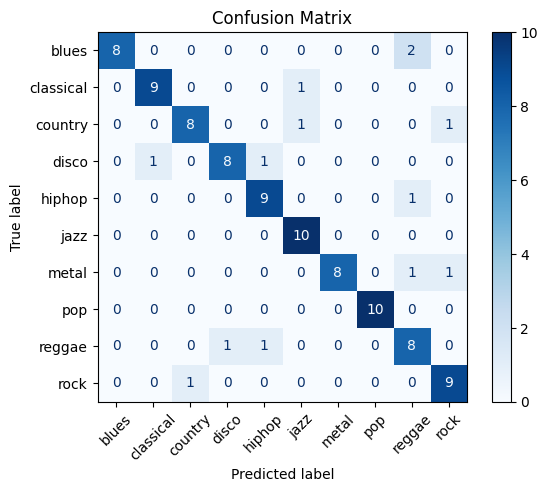


--- 分類詳細結果 ---

blues（共 10 首）
blues_1.wav -> 預測：blues, 機率：0.99
blues_2.wav -> 預測：blues, 機率：0.99
blues_3.wav -> 預測：blues, 機率：0.99
blues_4.wav -> 預測：blues, 機率：0.98
blues_5.wav -> 預測：blues, 機率：0.90
blues_6.wav -> 預測：blues, 機率：0.98
blues_7.wav -> 預測：blues, 機率：0.99
blues_8.wav -> 預測：blues, 機率：0.97
blues_9.wav -> 預測：reggae, 機率：0.86
blues_10.wav -> 預測：reggae, 機率：0.89

classical（共 10 首）
classical_1.wav -> 預測：classical, 機率：0.58
classical_2.wav -> 預測：classical, 機率：1.00
classical_3.wav -> 預測：classical, 機率：1.00
classical_4.wav -> 預測：classical, 機率：0.97
classical_5.wav -> 預測：classical, 機率：1.00
classical_6.wav -> 預測：classical, 機率：1.00
classical_7.wav -> 預測：jazz, 機率：0.96
classical_8.wav -> 預測：classical, 機率：0.98
classical_9.wav -> 預測：classical, 機率：1.00
classical_10.wav -> 預測：classical, 機率：1.00

country（共 10 首）
country_1.wav -> 預測：jazz, 機率：0.36
country_2.wav -> 預測：country, 機率：0.91
country_3.wav -> 預測：country, 機率：0.81
country_4.wav -> 預測：country, 機率：0.48
country_5.wav -> 預測：rock, 機率：0.66
country_6.wav -

In [16]:
# 準確率及混淆矩陣

genres = {
    'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4,
    'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9
}
genre_list = list(genres.keys())

# 模型
model_path = "/content/drive/MyDrive/cnn_transformer_model.h5"
model = load_model(model_path)

# 分類
def classify(file_path):
    y, sr = librosa.load(file_path, sr=22050)
    input_tensor = extract_features(y, sr)
    pred_probs = model.predict(input_tensor, verbose=0)
    pred_index = np.argmax(pred_probs, axis=1)[0]
    pred_prob = pred_probs[0][pred_index]
    return pred_index, pred_prob

# 分析
def evaluate_generated_audio(folder_path):
    y_true = []
    y_pred = []
    genre_counts = {g: 0 for g in genres}
    genre_correct = {g: 0 for g in genres}

    # 分類結果
    detailed_results = defaultdict(list)

    for filename in natsorted(os.listdir(folder_path)):
        if filename.endswith('.wav'):
            match = re.match(r"([a-z]+)[_-]", filename)
            if match:
                true_genre = match.group(1)
                if true_genre not in genres:
                    continue
                path = os.path.join(folder_path, filename)
                pred_index, pred_prob = classify(path)
                true_index = genres[true_genre]

                y_true.append(true_index)
                y_pred.append(pred_index)

                genre_counts[true_genre] += 1
                if pred_index == true_index:
                    genre_correct[true_genre] += 1

                pred_genre = genre_list[pred_index]
                detailed_results[true_genre].append((filename, pred_genre, pred_prob))

    # 每個風格的準確率
    accs = []
    for genre in genres:
        total = genre_counts[genre]
        correct = genre_correct[genre]
        acc = correct / total if total > 0 else 0
        accs.append(acc)
        print(f"{genre:10s}: {correct}/{total} = {acc:.2%}")

    # 平均準確率
    mean_acc = np.mean(accs)
    print(f"\n平均準確率: {mean_acc:.2%}")

    # confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=genre_list)
    disp.plot(xticks_rotation=45, cmap='Blues')
    plt.title("Confusion Matrix")
    plt.show()

    # 輸出詳細結果
    print("\n--- 分類詳細結果 ---")
    for genre in genres:
        files = detailed_results[genre]
        if not files:
            continue
        print(f"\n{genre}（共 {len(files)} 首）")
        for filename, pred_genre, pred_prob in files:
            print(f"{filename} -> 預測：{pred_genre}, 機率：{pred_prob:.2f}")

folder_path = "/content/drive/MyDrive/music_wav"
evaluate_generated_audio(folder_path)